In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

demo = pd.read_sas("P_DEMO.xpt", format='xport')      # Demographics
bmx = pd.read_sas("P_BMX.xpt", format='xport')        # Body Measures (anthropometric)
biopro = pd.read_sas("P_BIOPRO.xpt", format='xport')  # Biochemistry (ALT, AST, etc.)
cbc = pd.read_sas("P_CBC.xpt", format='xport')        # Complete Blood Count (platelets)
ghb = pd.read_sas("P_GHB.xpt", format='xport')        # Glycohemoglobin (HbA1c)
glu = pd.read_sas("P_GLU.xpt", format='xport')        # Glucose
hdl = pd.read_sas("P_HDL.xpt", format='xport')        # HDL cholesterol
trigly = pd.read_sas("P_TRIGLY.xpt", format='xport')  # Triglycerides
dib = pd.read_sas("P_DIQ.xpt", format='xport')
alc = pd.read_sas("P_ALQ.xpt", format='xport')

/Users/pranavmathur/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
df = demo

# Merging each additional dataframe on 'SEQN'
df = df.merge(bmx, on='SEQN', how='left')
df = df.merge(biopro, on='SEQN', how='left')
df = df.merge(cbc, on='SEQN', how='left')
df = df.merge(ghb, on='SEQN', how='left')
df = df.merge(glu, on='SEQN', how='left')
df = df.merge(hdl, on='SEQN', how='left')
df = df.merge(trigly, on='SEQN', how='left')
df = df.merge(dib, on='SEQN', how='left')
df = df.merge(alc, on='SEQN', how='left')

In [ ]:
columns_needed = [
    'SEQN', 'RIDAGEYR', 'RIAGENDR',       
    'BMXBMI', 'BMXWAIST',                  
    'LBXSATSI', 'LBXSASSI', 'LBXSGTSI',     
    'LBXGH', 'BMXHIP',                      
    'LBDHDD',                       
    'LBXPLTSI', 'LBXSUA', 'LBXSTR',     
    'LBXSGL', 'BMXHT'
]
df = df[columns_needed]

In [4]:
df = df.dropna(subset=columns_needed)

In [5]:
missing_percent = df.isnull().sum() / len(df) * 100
print(missing_percent)

SEQN        0.0
RIDAGEYR    0.0
RIAGENDR    0.0
BMXBMI      0.0
BMXWAIST    0.0
LBXSATSI    0.0
LBXSASSI    0.0
LBXSGTSI    0.0
LBXGH       0.0
BMXHIP      0.0
LBDHDD      0.0
LBXPLTSI    0.0
LBXSUA      0.0
LBXSTR      0.0
LBXSGL      0.0
BMXHT       0.0
dtype: float64


In [6]:
lux = pd.read_sas("P_LUX.xpt", format='xport')

In [7]:
lux = lux[lux['LUAXSTAT'] == 1]

In [8]:
lux = lux.dropna(subset=['LUXCAPM'])

In [9]:
lux.loc[:, 'NAFLD'] = (lux['LUXCAPM'] >= 248).astype(int)

In [ ]:
df = df.merge(lux[['SEQN', 'NAFLD']], on='SEQN', how='inner')

In [11]:
df['waist_hip_ratio'] = df['BMXWAIST'] / df['BMXHIP']
df['waist_height_ratio'] = df['BMXWAIST'] / df['BMXHT']

In [12]:
X = df.drop(columns=['SEQN', 'NAFLD'])
y = df['NAFLD']

In [ ]:
X = df.drop(columns=['SEQN', 'NAFLD'])
y = df['NAFLD']

# Normalizing features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Converting back to DataFrame for easier handling
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

In [14]:
X = X_normalized_df

In [ ]:
def compare_feature_methods(X, y):
    # Feature Selection
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X, y)
    selector = SelectFromModel(rf, prefit=True, threshold='median')
    X_selected = selector.transform(X)
    
    # PCA
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X)
    
    # Evaluate with Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Feature Selection Performance
    score_selected = cross_val_score(rf, X_selected, y, cv=skf, scoring='accuracy').mean()
    # PCA Performance
    score_pca = cross_val_score(rf, X_pca, y, cv=skf, scoring='accuracy').mean()
    
    print(f"Feature Selection Accuracy: {score_selected:.3f}")
    print(f"PCA Accuracy: {score_pca:.3f}")
    return X_selected if score_selected > score_pca else X_pca

# Usage:
X_processed = compare_feature_methods(X_normalized_df, y)

/Users/pranavmathur/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Feature Selection Accuracy: 0.771
PCA Accuracy: 0.767


In [16]:
import optuna
from xgboost import XGBClassifier

def optimize_hyperparams(X, y):
    def objective(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 3)
        }
        model = XGBClassifier(**params, random_state=42, eval_metric='logloss')
        score = cross_val_score(model, X, y, cv=StratifiedKFold(5), scoring='accuracy').mean()
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    print("Best accuracy:", study.best_value)
    return study.best_params

# Usage:
best_params = optimize_hyperparams(X_processed, y)


[I 2025-06-12 12:16:26,370] A new study created in memory with name: no-name-6807d6f4-eee6-40d8-9f92-297be6024d7c
[I 2025-06-12 12:16:29,845] Trial 0 finished with value: 0.7736907730673317 and parameters: {'learning_rate': 0.01580395117195678, 'n_estimators': 932, 'max_depth': 6, 'subsample': 0.772540766323407, 'colsample_bytree': 0.8617101190949236, 'reg_alpha': 0.484292279166604, 'reg_lambda': 1.3100383549428283}. Best is trial 0 with value: 0.7736907730673317.
[I 2025-06-12 12:16:32,010] Trial 1 finished with value: 0.7552369077306734 and parameters: {'learning_rate': 0.14716045682180967, 'n_estimators': 684, 'max_depth': 6, 'subsample': 0.9491426428396559, 'colsample_bytree': 0.82235844424759, 'reg_alpha': 0.23485961004030487, 'reg_lambda': 2.6570265427662902}. Best is trial 0 with value: 0.7736907730673317.
[I 2025-06-12 12:16:35,192] Trial 2 finished with value: 0.756359102244389 and parameters: {'learning_rate': 0.09038517948392515, 'n_estimators': 689, 'max_depth': 7, 'subsamp

[I 2025-06-12 12:17:37,573] Trial 23 finished with value: 0.7744389027431422 and parameters: {'learning_rate': 0.015174397878196211, 'n_estimators': 783, 'max_depth': 7, 'subsample': 0.814849721129986, 'colsample_bytree': 0.9463363595105887, 'reg_alpha': 0.8598408682286475, 'reg_lambda': 1.004695766003913}. Best is trial 11 with value: 0.7761845386533667.
[I 2025-06-12 12:17:39,610] Trial 24 finished with value: 0.7766832917705736 and parameters: {'learning_rate': 0.011130169482497171, 'n_estimators': 926, 'max_depth': 4, 'subsample': 0.8607695271379922, 'colsample_bytree': 0.8416367080024787, 'reg_alpha': 0.33670949449600385, 'reg_lambda': 1.8391192248387842}. Best is trial 24 with value: 0.7766832917705736.
[I 2025-06-12 12:17:45,309] Trial 25 finished with value: 0.7608478802992519 and parameters: {'learning_rate': 0.048268647659011024, 'n_estimators': 911, 'max_depth': 9, 'subsample': 0.8638046187558387, 'colsample_bytree': 0.8443650245932055, 'reg_alpha': 0.3683320479698182, 'reg_

[I 2025-06-12 12:18:21,295] Trial 46 finished with value: 0.7736907730673317 and parameters: {'learning_rate': 0.0210420565391901, 'n_estimators': 947, 'max_depth': 5, 'subsample': 0.7181676903699905, 'colsample_bytree': 0.935159741795586, 'reg_alpha': 0.279984587450374, 'reg_lambda': 2.192405761310431}. Best is trial 34 with value: 0.7778054862842894.
[I 2025-06-12 12:18:21,565] Trial 47 finished with value: 0.7765586034912719 and parameters: {'learning_rate': 0.055749596801289124, 'n_estimators': 129, 'max_depth': 3, 'subsample': 0.8937461625751641, 'colsample_bytree': 0.9934307698073657, 'reg_alpha': 0.4168483477016566, 'reg_lambda': 2.753644968448551}. Best is trial 34 with value: 0.7778054862842894.
[I 2025-06-12 12:18:22,950] Trial 48 finished with value: 0.774064837905237 and parameters: {'learning_rate': 0.030900189037862916, 'n_estimators': 513, 'max_depth': 5, 'subsample': 0.7435666605243575, 'colsample_bytree': 0.8580864006726125, 'reg_alpha': 0.14266935349260568, 'reg_lambd

Best accuracy: 0.7778054862842894


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       745
           1       0.76      0.80      0.78       859

    accuracy                           0.76      1604
   macro avg       0.76      0.75      0.75      1604
weighted avg       0.76      0.76      0.75      1604

AUC: 0.8426264346711878


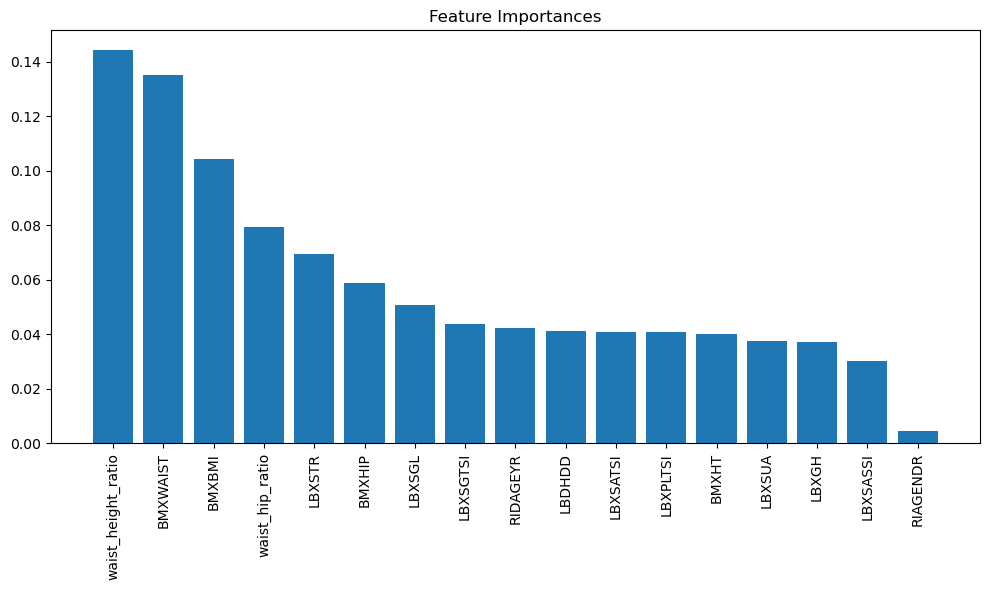

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [22]:
# Train with best parameters
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(X_processed, y)

# Evaluate
y_pred = final_model.predict(X_processed)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3726
           1       0.83      0.86      0.84      4294

    accuracy                           0.83      8020
   macro avg       0.83      0.83      0.83      8020
weighted avg       0.83      0.83      0.83      8020



In [24]:
print("AUC:", roc_auc_score(y_test, y_proba))

AUC: 0.8426264346711878


In [ ]:
# Save the model
import joblib
joblib.dump(final_model, 'final_xgb_model.joblib')

# Saveing the scaler
# joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

# MODEL USAGE FOR LATER USE

In [ ]:
# import joblib
# joblib.dump(model, 'my_model.joblib')
# import joblib

# # Load the saved model
# loaded_model = joblib.load('my_model.joblib')
# predictions = loaded_model.predict(X_new)

In [ ]:
# joblib.dump(scaler, 'scaler.joblib')
# scaler = joblib.load('scaler.joblib')
# X_new_scaled = scaler.transform(X_new)
# predictions = loaded_model.predict(X_new_scaled)